# Exploratory Data Analysis (EDA) with Housing Price Dataset (Part II - Bivariate Analysis)


Bivariate analysis is the simultaneous analysis of two variables (attributes). It helps to understand the relationships and patterns between these variables. Depending on the types of variables being analyzed, various techniques and visualizations can be employed.

- Categorical (incl. Discrete numerical) VS Categorical
    - Crosstab
    - Chi-square tests, Cramér's V
    - Visualization: 
        - Stacked or grouped bar charts
        - Frequency heat maps
    
- Categorical VS Continuous
    - Visualization: 
        - Violin Plots
        - Bar Charts
        - Side by side Box Plots

- Continuous VS Continuous
    - Correlation coefficients
    - Visualization: 
        - Scatter plots
        - Line plots
        - Correlation Heatmaps
        - QQ Plot


## Loading and preparing the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
# Loading the housing price dataset (assuming the file name is "housing_price.csv")
df = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/housing_price_eda.csv")

In [3]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]

In [4]:
# Removing the "Id" column from the dataframe
df.drop("Id", inplace=True, axis=1)

In [5]:
# Separating between discrete and continuous variables, as discrete ones could potentially be treated as categorical.
# Remember to adjust the threshold (in this case, < 20) based on your dataset's specific characteristics and domain knowledge.
potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]
potential_categorical_from_numerical

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold,YrSold
0,60,7,5,1,0,2,1,3,1,8,0,2,0,2,2008
1,20,6,8,0,1,2,0,3,1,6,1,2,0,5,2007
2,60,7,5,1,0,2,1,3,1,6,1,2,0,9,2008
3,70,7,5,1,0,1,0,3,1,7,1,3,0,2,2006
4,60,8,5,1,0,2,1,4,1,9,1,3,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,5,0,0,2,1,3,1,7,1,2,0,8,2007
1456,20,6,6,1,0,2,0,3,1,7,2,2,0,2,2010
1457,70,7,9,0,0,2,0,4,1,9,2,1,0,5,2010
1458,20,5,6,1,0,1,0,2,1,5,0,1,0,4,2010


In [6]:
# Extracting columns with object (typically string) data types to create a categorical dataframe
# For demonstration purposes, let's consider the columns in potential_categorical_from_numerical as categorical variables.
df_categorical = pd.concat([df.select_dtypes("object"), potential_categorical_from_numerical], axis=1)

# Adjusting the numerical dataframe by removing the moved columns
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

## Categorical (incl. Discrete numerical) VS Categorical

Let's explore the concept of **analyzing relationships between categorical variables**. We'll do so using statistical tests such as the **chi-square (χ²) test and Cramer's V**, and using visualization tools such as stacked or grouped bar charts. 

### Crosstab
A table showing the frequency of occurrences for combinations of two categorical variables.

We'll begin by creating a crosstab between 'MSZoning' and 'SaleCondition' to observe the interaction between these two categorical variables.

In [7]:
# Generating a crosstab for 'MSZoning' and 'SaleCondition'
crosstab_result = pd.crosstab(df['MSZoning'], df['SaleCondition'])

crosstab_result

SaleCondition,Abnorml,AdjLand,Alloca,Family,Normal,Partial
MSZoning,,,,,,
C (all),5,0,1,0,4,0
FV,4,0,0,0,39,22
RH,5,0,0,0,11,0
RL,70,4,9,14,955,99
RM,17,0,2,6,189,4


From the crosstab between `MSZoning` and `SaleCondition`, we observe the following:
- Most houses have a `Normal` sale condition.
- Most houses in the RL (Residential Low Density) zoning area have a `Normal` sale condition, followed by `Partial` and then `Abnorml`.
- The FV (Floating Village Residential) zoning area has a notable number of houses with a `Partial` sale condition, suggesting newer homes or homes that underwent significant renovations.
- The C (all) (Commercial) zoning category mostly consists of houses with `Abnorml` and `Normal` sale conditions. But we have less data of this kind.

### Chi-square Tests
Tests the independence of two categorical variables by comparing observed frequencies to expected frequencies.

- The chi-square test is a statistical test used to **determine whether there is a significant association between two categorical variables**. 
- Interpretation: if p-value < 0.05, this suggests that there is a significant association between the categorical variables. P-value >= 0.05, indicates that there is not enough evidence to conclude a significant association between the variables. 


Let's perform a Chi-square test for `MSZoning` and `SaleCondition` to determine if they are independent.

In [8]:
from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(127.83725428196675, 9.909275301032864e-18)


The null hypothesis of the Chi-square test is that the two categorical variables are independent. Given the extremely low \( p \)-value, we reject the null hypothesis. This implies that there's a significant association between `MSZoning` and `SaleCondition` in the dataset.


### Cramér's V

While the Chi-square test informs us about the independence of two categorical variables, Cramér's V measures the strength of the association between them. 

- Cramer's V is a measure of association used to **quantify the strength of the relationship between categorical variables**. 
- Interpretation: Cramer's V ranges from 0 to 1, where **0 indicates no association, and 1 represents a perfect association between the variables**. A higher value of Cramer's V indicates a stronger relationship between the categorical variables.

Let's compute Cramér's V for `MSZoning` and `SaleCondition` to measure the strength of their association.

In [9]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.14795249508442443

The Cramér's V value of 0.148 suggests a weak association between the two variables. Though statistically significant, the strength of this relationship is not very strong in practical terms.

### Stacked and Grouped Bar Charts
Visualizes the frequency or proportion of categories between two categorical variables.

<Axes: xlabel='MSZoning'>

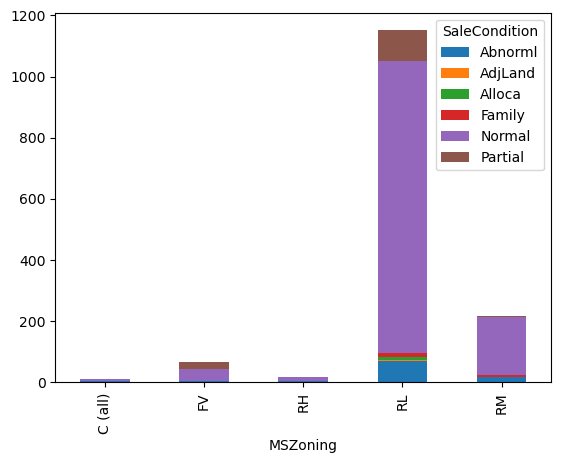

In [10]:
# Plotting a stacked bar chart for the 'crosstab_result' data
crosstab_result.plot(kind="bar", stacked=True)

- The chart vividly illustrates the dominance of the `RL` (Residential Low Density) zoning category in house sales. This category has the most diverse set of `SaleCondition` values, further highlighting its prevalence in the dataset.
- Other zoning categories, like `FV`, `RH`, and `RM`, also predominantly exhibit `Normal` sale conditions.
- It's evident that `Partial` sales are primarily associated with the `RL` and `FV` zoning categories.


Let's look now at a grouped bar chart for the same columns:

<Axes: xlabel='MSZoning', ylabel='count'>

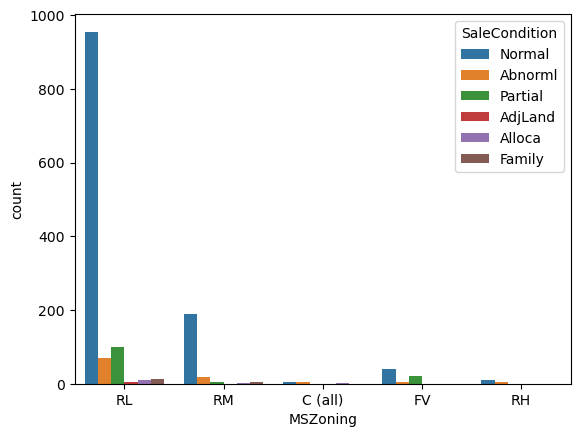

In [11]:
# Plotting a grouped bar chart
sns.countplot(data=df, x='MSZoning', hue='SaleCondition')

#### Seaborn Visualizations and Hue

There are a couple of Seaborn visualizations that allow us to add a categorical variable in the parameter `hue`. By using the `hue` parameter, we can add another dimension of information to our plots. 

### Frequency Heat Maps
Displays frequencies using color gradients for combinations of two categorical variables.

<Axes: xlabel='SaleCondition', ylabel='MSZoning'>

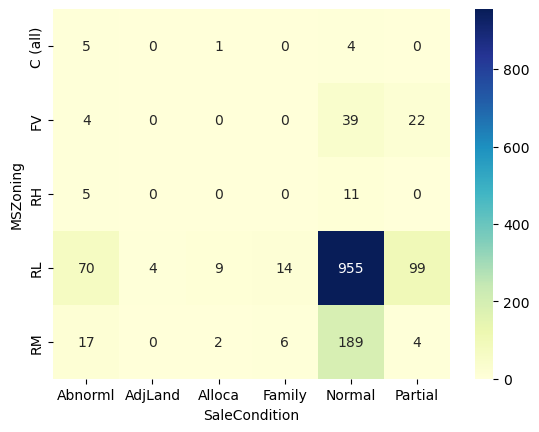

In [12]:
import seaborn as sns

# Plotting a heatmap for the 'crosstab_result' data, annotating each cell with the value, using the "YlGnBu" color map and formatting numbers as integers
sns.heatmap(crosstab_result, annot=True, cmap="YlGnBu", fmt="d")

- The heatmap color intensity shows the frequency count of house sales for each combination of `MSZoning` and `SaleCondition`.
- The darker shades in the `RL` and `Normal` intersection reiterate the high occurrence of this combination.
- There are specific combinations with no occurrences, such as `C (all)` with `Partial` and `RH` with `Partial`, evident from the zeros in the heatmap.


---

## Categorical vs Continuous

We'll use the `MSZoning` as our categorical variable and `SalePrice` as our continuous variable.

### Violin Plots
Combines a box plot with a kernel density plot to show the distribution of a continuous variable for each category.

The violin plot below will provide a combined view of the distribution of `SalePrice` for each zoning category:

C:\Users\UTILISATEUR\AppData\Local\Temp\ipykernel_22296\2909781400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='MSZoning', y='SalePrice', palette="coolwarm")


<Axes: xlabel='MSZoning', ylabel='SalePrice'>

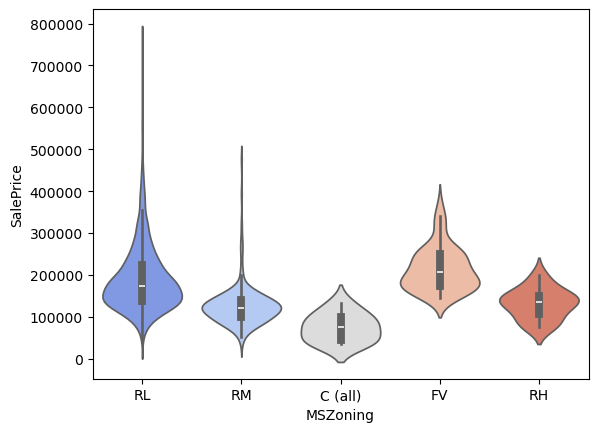

In [13]:
# Plotting a violin plot to visualize the distribution of 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.violinplot(data=df, x='MSZoning', y='SalePrice', palette="coolwarm")

- The `RL` (Residential Low Density) category displays a wide range of house prices, with a thicker section around the median, suggesting that most houses in this category fall within this price range.
- The `RM` (Residential Medium Density) category has a more condensed price distribution, with a majority of houses priced in the lower to mid-range.
- The `FV` (Floating Village Residential) category has a bimodal distribution, indicating two major groups of house prices.
- The `RH` (Residential High Density) and `C (all)` (Commercial) categories have fewer data points, but their price distributions are somewhat similar to `RM`.

### Bar Charts
Shows the mean (or another measure of central tendency) of the continuous variable for each category.

This will show the mean (or another measure of central tendency) of the `SalePrice` for each zoning category.

In [ ]:
df_avg = df.groupby('MSZoning')['SalePrice'].mean()
fig = px.histogram(x=df_avg.index, y=df_avg.values)

C:\Users\UTILISATEUR\AppData\Local\Temp\ipykernel_22296\2304236874.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='MSZoning', y='SalePrice', palette="coolwarm")


<Axes: xlabel='MSZoning', ylabel='SalePrice'>

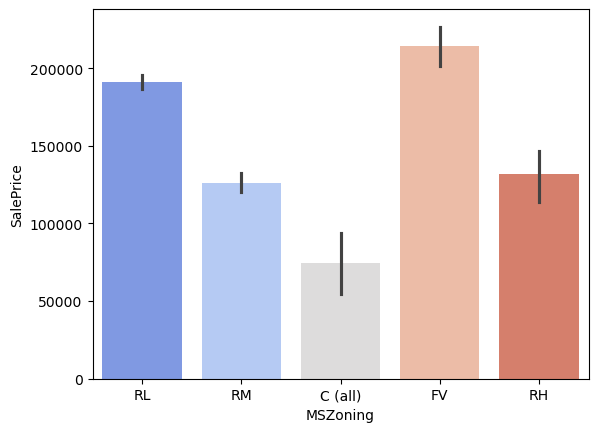

In [14]:
# Plotting a bar plot to visualize the average 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.barplot(data=df, x='MSZoning', y='SalePrice', palette="coolwarm")

The bar chart above depicts the average `SalePrice` for each zoning category:

- The `FV` (Floating Village Residential) category has the highest average house price, closely followed by the `RL` (Residential Low Density) category.
- The `RM` (Residential Medium Density) and `RH` (Residential High Density) categories have relatively lower average house prices.
- The `C (all)` (Commercial) category's average house price is the lowest among all the categories.

It's evident that the type of zoning has a considerable impact on the average house price, with certain zones fetching higher prices on average.

### Side by Side Box Plots

Box plots are a great way to visualize the distribution of a continuous variable across different categories. They show the median, quartiles, and potential outliers, providing a quick snapshot of the data's spread and central tendency.

Let's visualize the distribution of `SalePrice` for each zoning category using side-by-side box plots. This will help us understand the spread, median, and potential outliers for each category.

C:\Users\UTILISATEUR\AppData\Local\Temp\ipykernel_22296\1470081228.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='MSZoning', y='SalePrice', palette="coolwarm")


<Axes: xlabel='MSZoning', ylabel='SalePrice'>

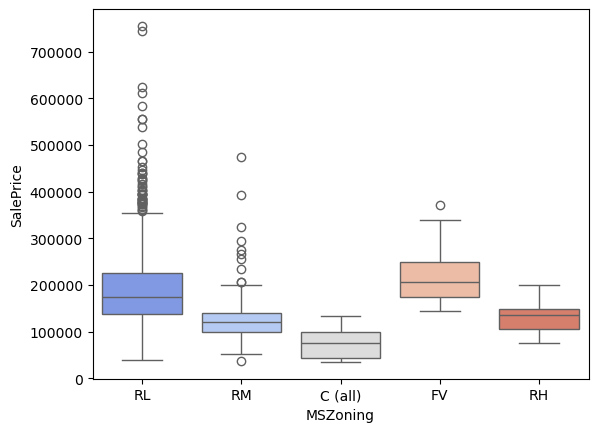

In [15]:
# Plotting a box plot to visualize the spread and outliers of 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.boxplot(data=df, x='MSZoning', y='SalePrice', palette="coolwarm")

- The `FV` (Floating Village Residential) and `RL` (Residential Low Density) zoning categories generally have higher median sale prices compared to other categories.
- The `RL` category, while having a high median sale price, also exhibits a wide range of sale prices, suggesting variability in the type of houses within this category.
- The `C (all)` (Commercial) category has the lowest median sale price and the smallest interquartile range, indicating lesser variability in sale prices within this category.
- The `RM` (Residential Medium Density) category has a lower median sale price compared to `RL` and `FV` but a higher median than the `RH` (Residential High Density) and `C (all)` categories.
- There are noticeable outliers in the `RL` and `RM` categories, with some houses selling at prices much higher than the typical range for those categories.

---

## Continuous vs Continuous

For this Continuous vs Continuous analysis, let's focus on two continuous variables: `SalePrice` and `GrLivArea` (Above grade (ground) living area square feet). These two variables are often of interest in housing datasets as they represent the sale price and the living area of a house, respectively.

### Correlation coefficients
Quantifies the strength and direction of the relationship between two continuous variables.

We'll begin by calculating the Pearson correlation coefficient between `SalePrice` and `GrLivArea` to quantify their linear relationship.

In [16]:
# Calculating the Pearson correlation coefficient between 'SalePrice' and 'GrLivArea' columns
correlation = df['SalePrice'].corr(df['GrLivArea'])
correlation

0.7086244776126522

Let's check the Spearman correlation coefficient between `SalePrice` and `GrLivArea`.

In [17]:
# Calculating the Spearman rank correlation between 'SalePrice' and 'GrLivArea' 
correlation = df['SalePrice'].corr(df['GrLivArea'], method='spearman')
correlation

0.7313095834659141

- **Pearson Correlation**: \(0.7086\)
- **Spearman Correlation**: \(0.7313\)

**Insights:**

- The **Pearson correlation** of \(0.7086\) suggests a strong positive linear relationship between the sale price of a house and its above-ground living area in square feet. As the living area increases, the sale price tends to increase as well.
  
- The **Spearman correlation** of \(0.7313\) indicates a strong positive monotonic relationship between the two variables. This means that when one variable increases, the other also tends to increase, but not necessarily at a constant rate. 

The slightly higher value for Spearman correlation suggests that there might be some non-linear aspects to their relationship or the presence of outliers affecting the Pearson correlation.

In essence, both correlations emphasize that homes with larger living areas above ground tend to sell at higher prices.

Let's calculate the Spearman correlation coefficients between `SalePrice` and all other numerical variables:

In [18]:
# Calculating the Spearman correlation coefficients between 'SalePrice' and all other numerical variables
spearman_correlations = df_numerical.corrwith(df['SalePrice'], method='spearman')

# Sorting the correlations for better visualization
spearman_correlations_sorted = spearman_correlations.sort_values(ascending=False)

# Displaying the correlations
spearman_correlations_sorted

SalePrice        1.000000
GrLivArea        0.731310
YearBuilt        0.652682
GarageArea       0.649379
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
WoodDeckSF       0.353802
BsmtFinSF1       0.301871
2ndFlrSF         0.293598
BsmtUnfSF        0.185197
ScreenPorch      0.100070
3SsnPorch        0.065440
BsmtFinSF2      -0.038806
MiscVal         -0.062727
LowQualFinSF    -0.067719
EnclosedPorch   -0.218394
dtype: float64

- Variables like `OverallQual`, `GrLivArea`, and `GarageCars` have strong positive correlations with `SalePrice`, suggesting that as these variables increase, the sale price of the house also tends to increase.
- On the other hand, variables like `EnclosedPorch`, `KitchenAbvGr`, and `OverallCond` have negative correlations with `SalePrice`, indicating that as these variables increase, the sale price tends to decrease.
- Some variables, such as `MSSubClass`, `BsmtHalfBath`, and `Id`, have correlations close to zero, suggesting a weak or no relationship with the sale price.

Remember, correlation values range from -1 to 1:
- A value close to 1 implies a strong positive correlation.
- A value close to -1 implies a strong negative correlation.
- A value close to 0 implies little to no linear/monotonic correlation.

**CAUTION!** The fact that correlation is zero does not mean there are no patterns. It means there is no linear or monotonic relationship.

### Correlation Heatmaps
Visualizes correlation coefficients between pairs of continuous variables using color gradients.

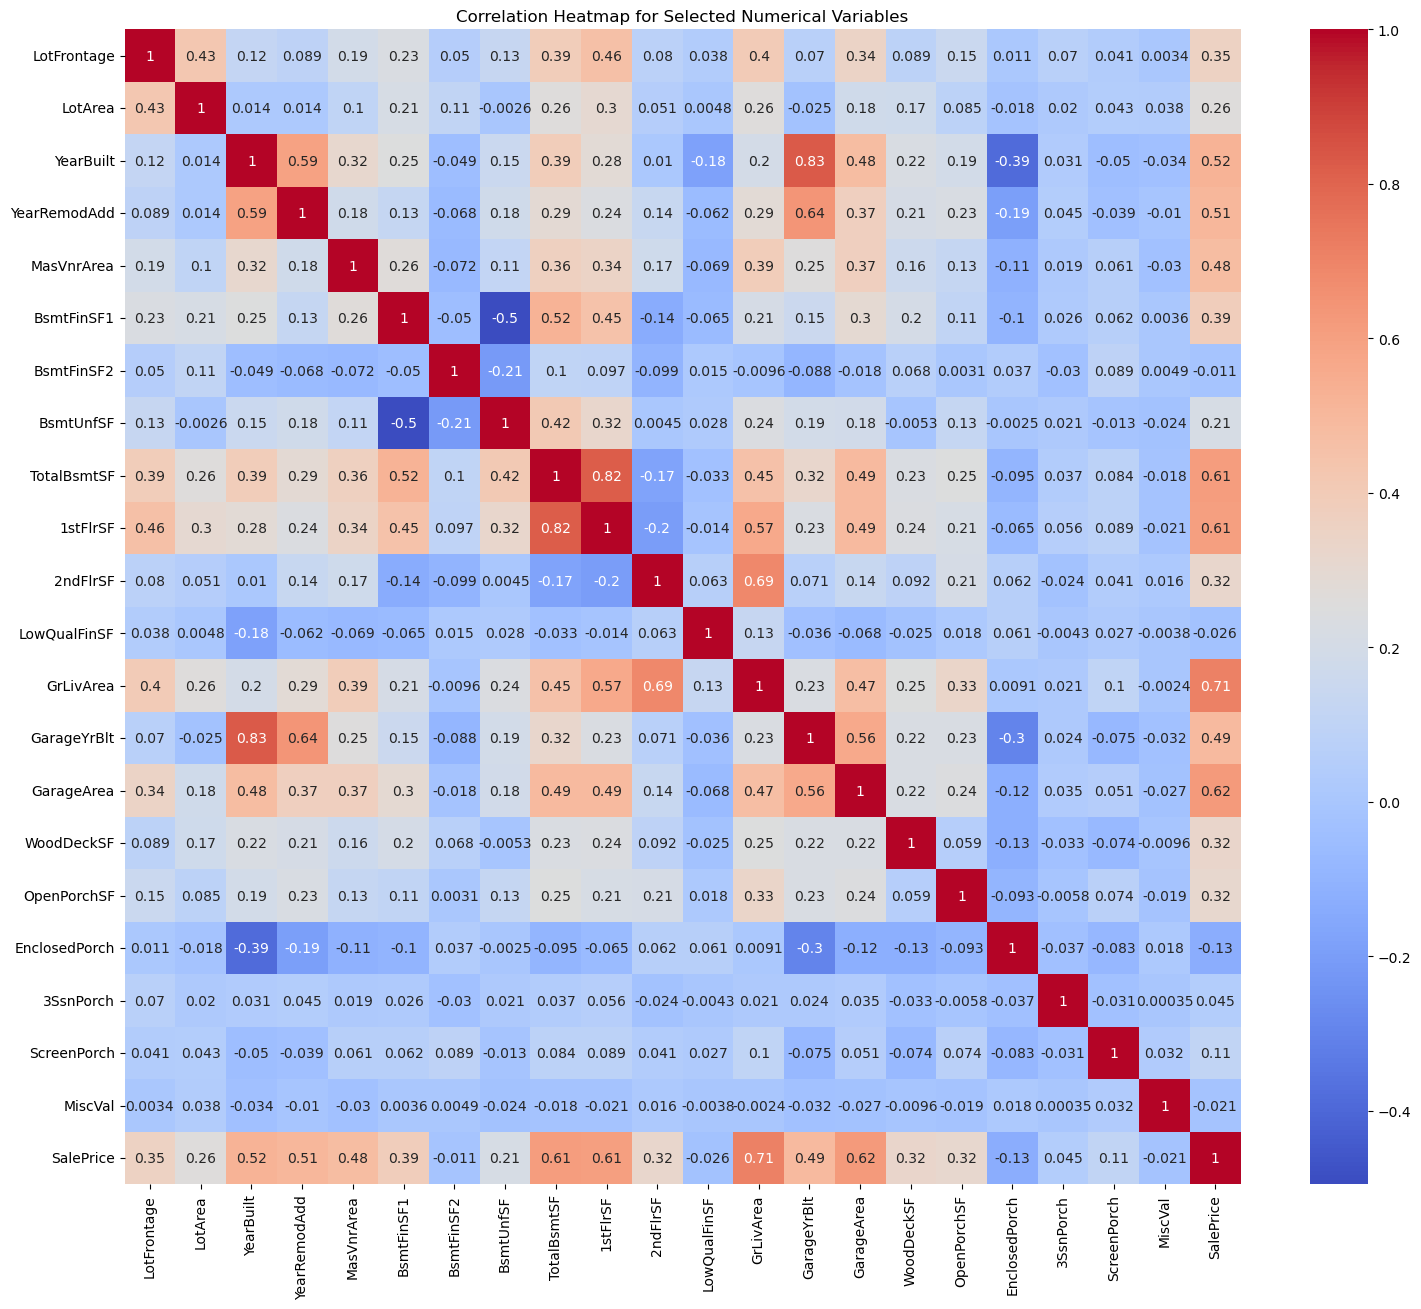

In [19]:
correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()
# Creating the mask to hide the upper triangle

#mask = np.triu(np.ones_like(data, dtype=bool))  # Hides the upper triangle

# Creating the heatmap with the mask

#sns.heatmap(data, mask=mask, cmap="coolwarm", annot=True)

#plt.show()

**Insights:**

- **Strong Positive Correlation**: Variables like `GrLivArea`, `1stFlrSF`, and `TotalBsmtSF` have strong positive correlations with `SalePrice`. This suggests that houses with larger living areas, larger first floors, or larger basements generally have higher sale prices.
- **Year of Construction**: Both `YearBuilt` and `YearRemodAdd` (year of remodeling) have a positive correlation with `SalePrice`, indicating that newer homes or homes that were more recently remodeled tend to fetch higher prices.
- **Garage**: The `GarageYrBlt` (year garage was built) and `GarageArea` show a positive correlation with `SalePrice`, suggesting that houses with newer and larger garages might be priced higher.
- **Multicollinearity**: Some variables, like `TotalBsmtSF` and `1stFlrSF`, have a strong correlation with each other. This is expected as the size of the first floor can often be similar to the total basement size. Such multicollinearity might need consideration when building predictive models.


We could also just do the Heatmap for those variables more correlated with SalePrice according to Spearman correlation coefficient.

In [20]:
spearman_correlations_sorted_top = spearman_correlations_sorted[abs(spearman_correlations_sorted) > 0.5]
spearman_correlations_sorted_top

SalePrice       1.000000
GrLivArea       0.731310
YearBuilt       0.652682
GarageArea      0.649379
TotalBsmtSF     0.602725
GarageYrBlt     0.593788
1stFlrSF        0.575408
YearRemodAdd    0.571159
dtype: float64

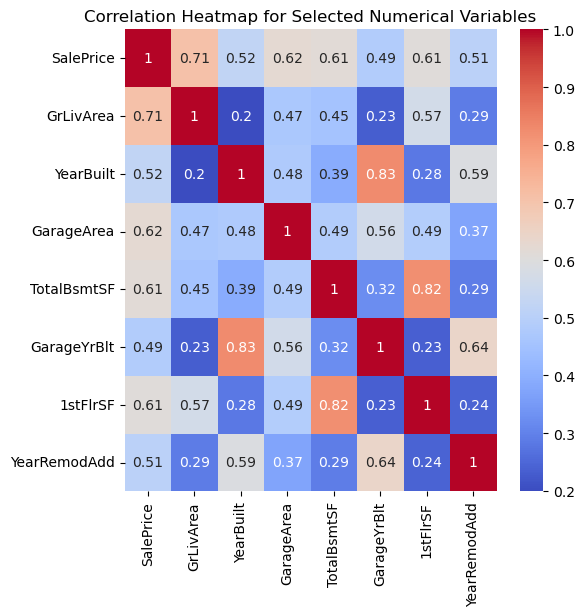

In [21]:
correlation_matrix = df_numerical[spearman_correlations_sorted_top.index].corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(6, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

### Scatter Plots
Plots individual data points based on their values for two continuous variables to visualize relationships.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

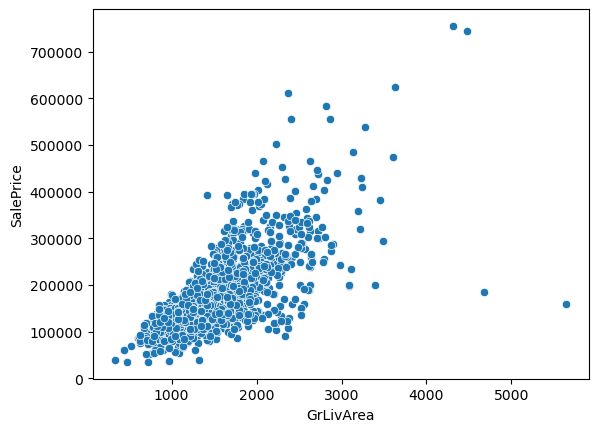

In [22]:
# Plotting a scatter plot to visualize the relationship between 'GrLivArea' and 'SalePrice'
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')

**Insights**:

- **Positive Relationship**: The plot clearly shows a positive relationship between the two variables. As the living area increases, the sale price of the houses generally increases as well.
  
- **Potential Outliers**: There are a few houses with large living areas but lower sale prices. These points could be potential outliers or could represent houses in areas where price per square foot is lower.

- **Data Concentration**: Most of the data points are concentrated in the area representing houses with living areas between approximately 1000 and 2500 square feet and sale prices between `$100,000` and `$300,000`. This suggests that the majority of the houses in the dataset fall within this range.

This scatter plot provides a visual confirmation of the strong positive relationship between the sale price and the living area of the houses, as indicated by the previously calculated correlation coefficients.

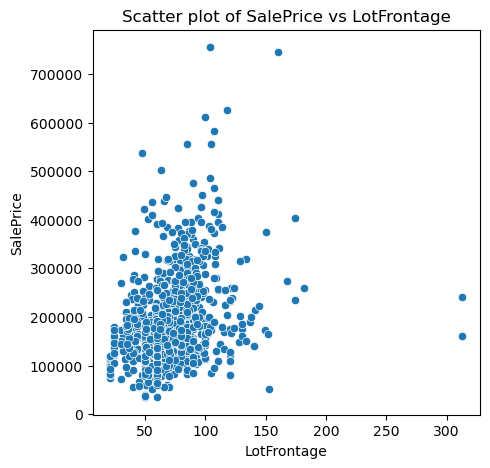

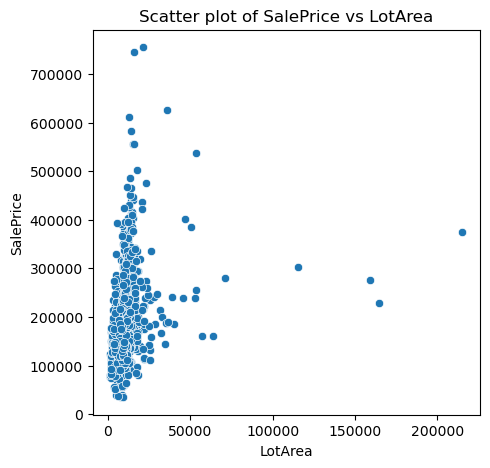

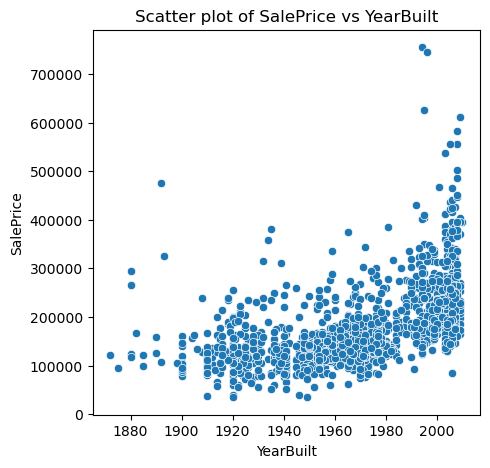

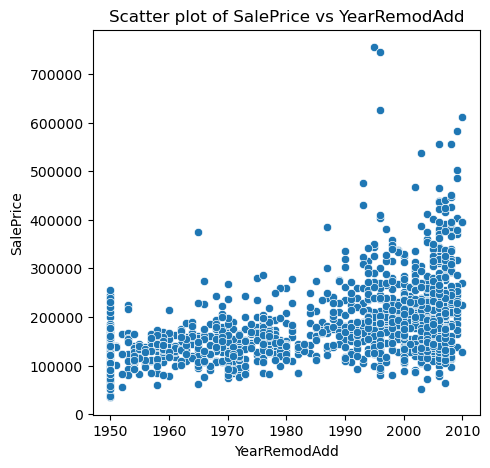

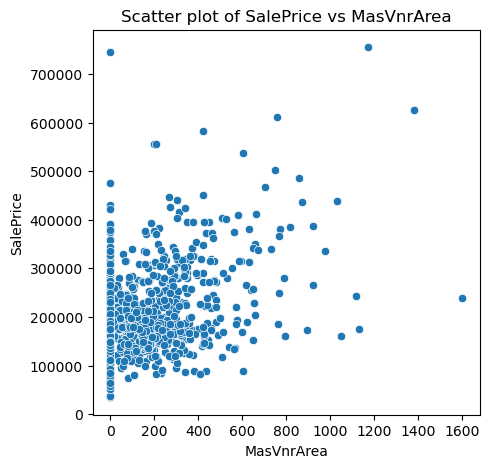

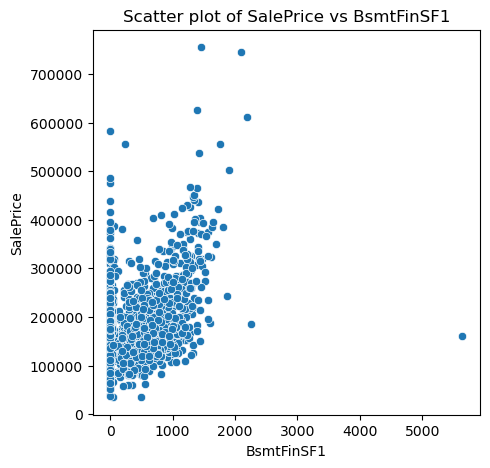

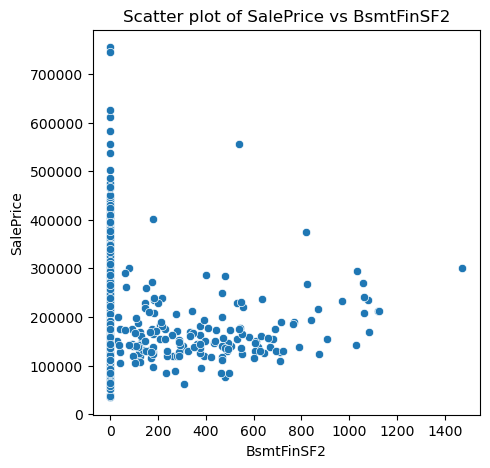

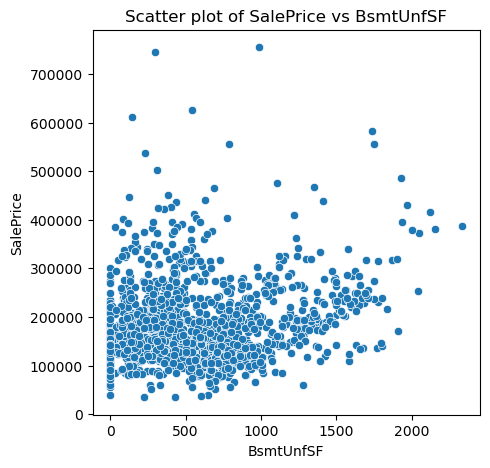

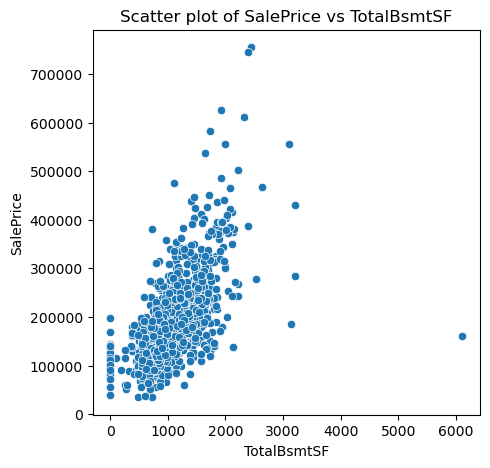

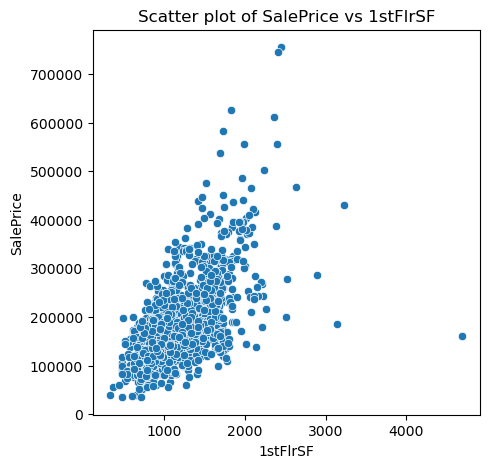

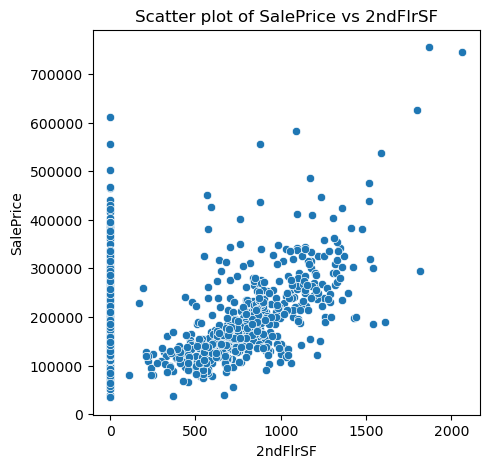

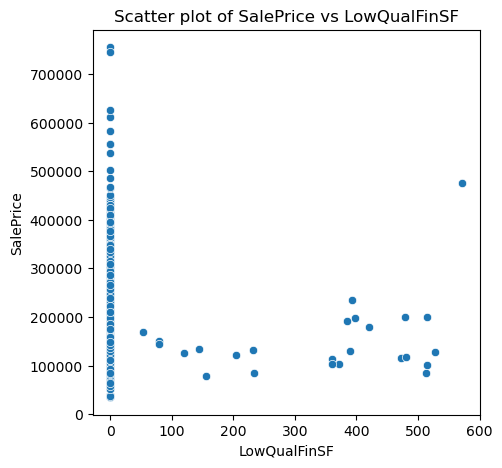

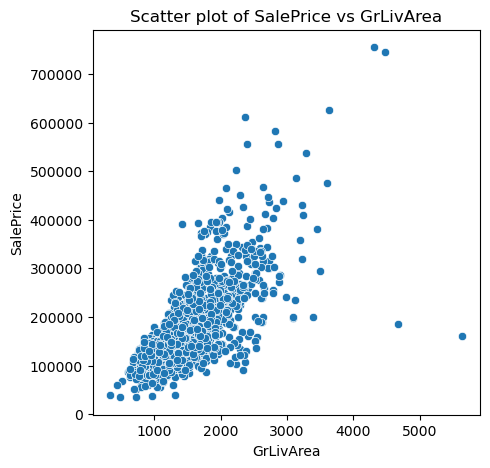

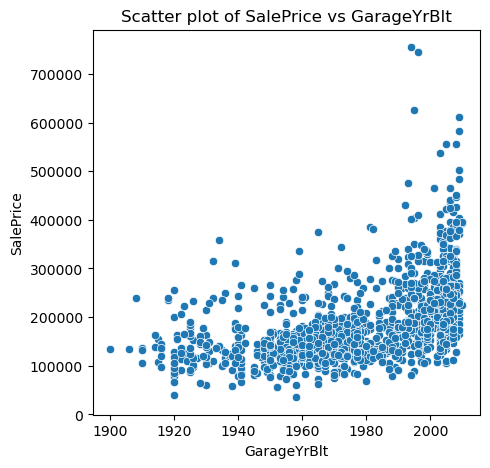

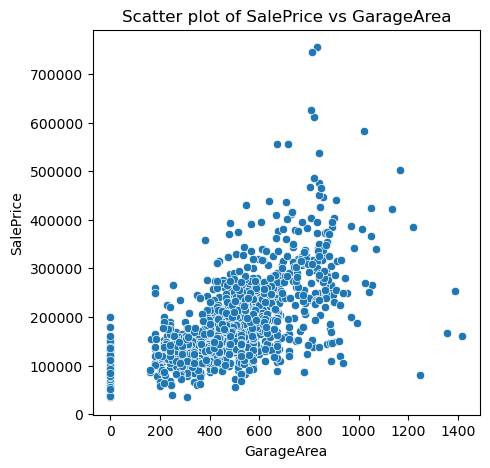

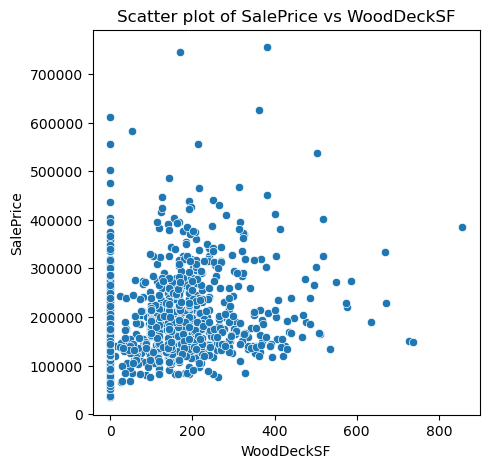

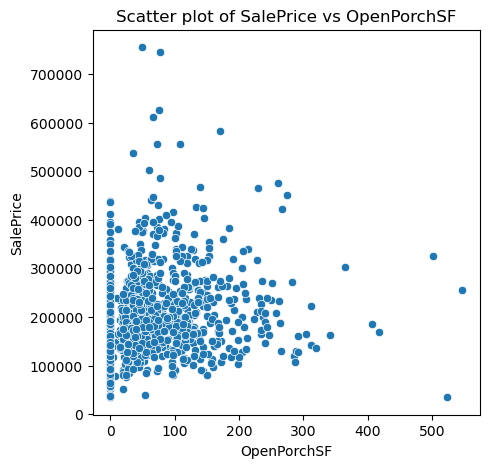

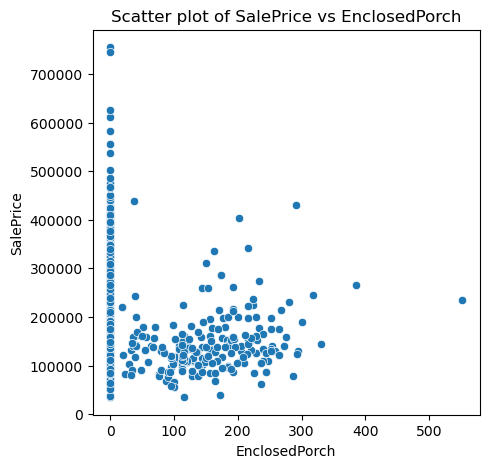

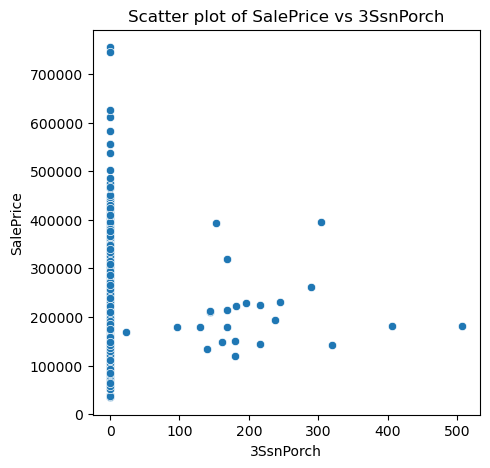

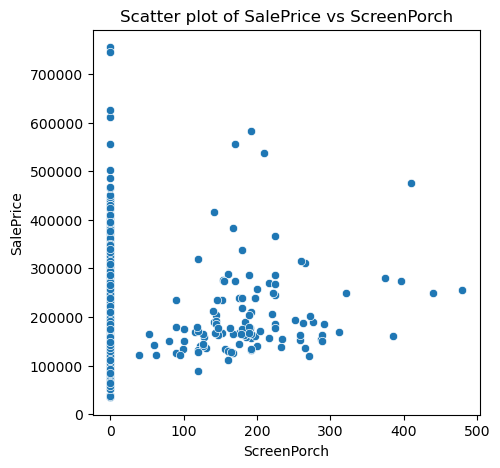

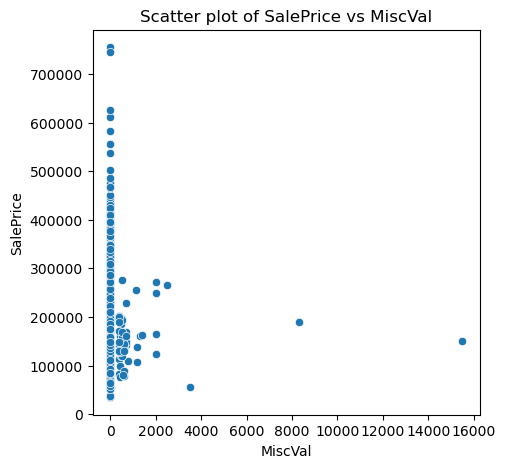

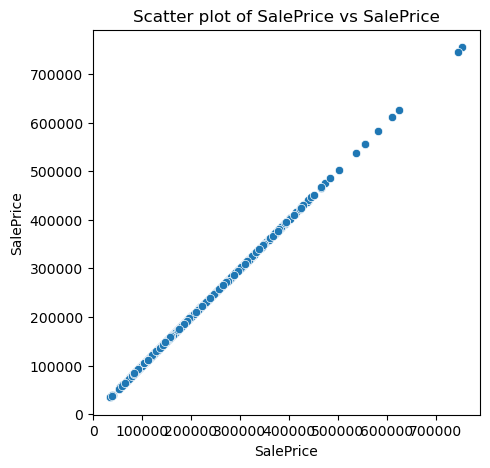

In [23]:
# Plotting scatter plots for each numerical column against 'SalePrice' to visualize their relationships
for col in df_numerical.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of SalePrice vs ' + col)
    sns.scatterplot(data=df, x=col, y='SalePrice')
    plt.show()

#### Seaborn Joint Plot

`sns.jointplot` is used to create a multi-panel figure that displays a bivariate (two-variable) relationship between two columns of a dataset along with the univariate (single-variable) distribution of each on separate axes.

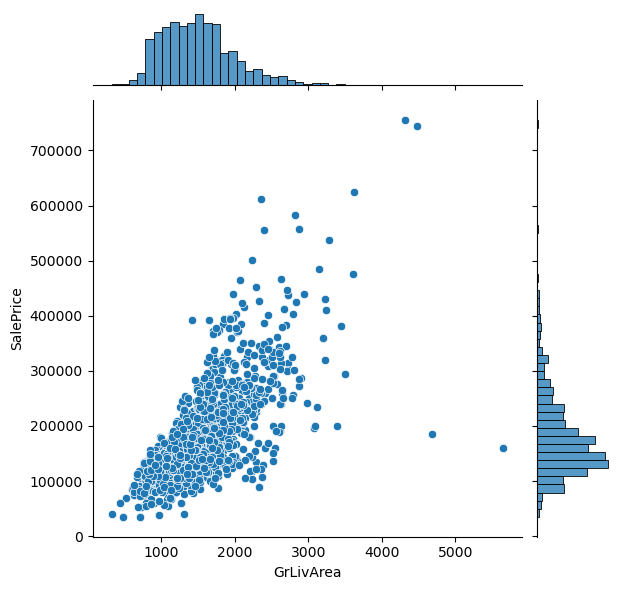

In [24]:
sns.jointplot(y=df_numerical['SalePrice'], x=df_numerical['GrLivArea'])

#### Seaborn Pairplot

`sns.pairplot()` is a function provided by the Seaborn library in Python to create a grid of scatter plots and histograms/KDEs for pairwise relationships in a dataset.

- **Pairwise Scatter Plots**: For each pair of numeric variables in the dataset, a scatter plot is created to visualize their relationship. This helps in spotting any linear or non-linear correlations between variables.
- **Histograms or KDE**: On the diagonal of the grid, sns.pairplot displays histograms (by default) or kernel density estimates (if specified) to show the univariate distribution of each variable.
- **Color by Categories**: You can use the hue parameter to color the data points based on a categorical variable. This can help in understanding how categories might affect relationships between numeric variables.

Let's visualize the pairwise relationship and distributions for "SalePrice" and "GrLivArea" using Seaborn's pairplot.

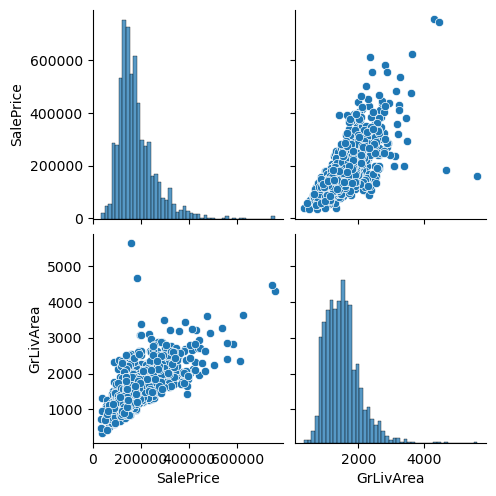

In [25]:
sns.pairplot(df[["SalePrice", "GrLivArea"]])

Now, let's visualize the pairwise relationships and distributions for all numerical columns in the dataframe 'df_numerical' using Seaborn's pairplot.

In [ ]:
sns.pairplot(df_numerical)

Now we will visualize the pairwise relationships and distributions for "SalePrice" and "GrLivArea" in the dataframe 'df', categorized by the "CentralAir" column using Seaborn's pairplot.

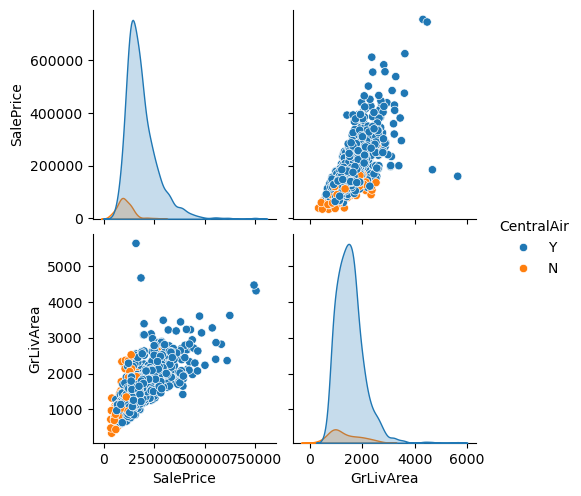

In [28]:
sns.pairplot(df[["SalePrice", "GrLivArea","CentralAir"]], hue='CentralAir')

#### Seaborn lmplot

**Scatter Plot with Regression Line**: By default, it displays a scatter plot of two variables along with a linear regression fit.

- **Color by Categories**: You can use the hue parameter to color the data points based on a categorical variable. This can help in understanding how categories might affect relationships between numeric variables.

We'll use Seaborn's lmplot to visualize the linear relationship between "GrLivArea" (x-axis) and "SalePrice" (y-axis) in the dataframe 'df'. The plot will also display a linear regression fit to the data points.

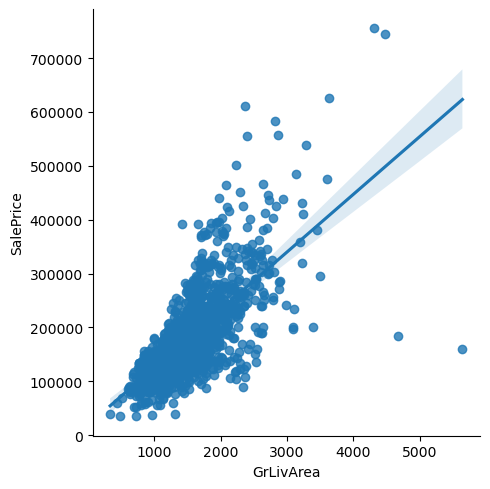

In [31]:
sns.lmplot(data=df,
            x='GrLivArea',
            y='SalePrice')


Using Seaborn's lmplot to visualize the linear relationship between "GrLivArea" (x-axis) and "SalePrice" (y-axis) in the dataframe 'df'. The data points are colored based on the "CentralAir" column to differentiate between houses with and without central air conditioning. The plot will also display separate linear regression fits for each "CentralAir" category.

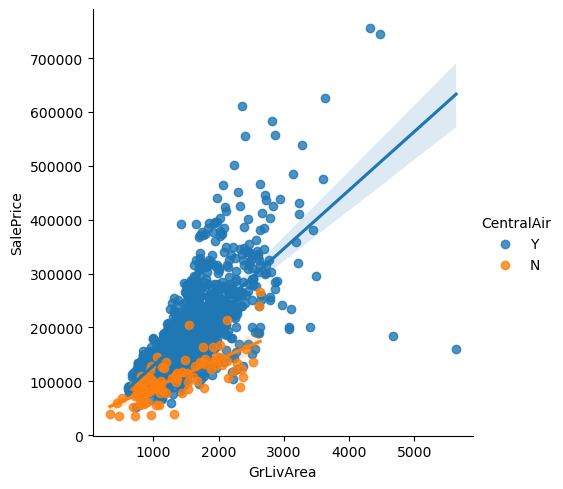

In [32]:
sns.lmplot(data=df,
            x='GrLivArea',
            y='SalePrice',
            hue='CentralAir')

### Line Plots
Connects individual data points with lines. A line plot is particularly useful for visualizing data over time. 

In the dataset, variables such as `YearBuilt` (original construction date) and `YearRemodAdd` (remodel date) are indicative of time. 

Let's visualize the average `SalePrice` over the years based on the `YearBuilt` variable. This will help us understand how the average price of houses has trended over the years they were built.

Here's a line plot that visualizes the median `SalePrice` of houses based on their construction year (`YearBuilt`).

C:\Users\UTILISATEUR\AppData\Local\Temp\ipykernel_22296\414903149.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='YearBuilt', y='SalePrice', ci=None)


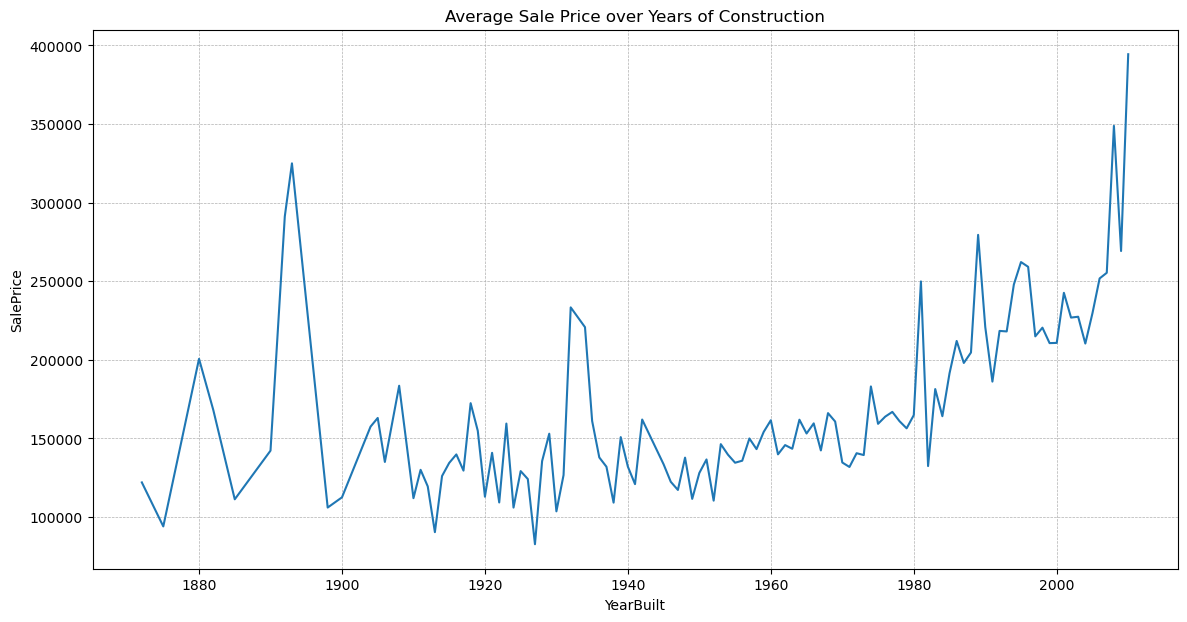

In [33]:
# Plotting a line graph to visualize the trend of average 'SalePrice' across different 'YearBuilt'
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='YearBuilt', y='SalePrice', ci=None)
plt.title('Average Sale Price over Years of Construction')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

**Insights:**

  
- **Recent Years**: There's a noticeable increase in median sale price for houses built in more recent years.

- **General Trend**: There's a clear upward trend in the average sale price over the years. This is expected due to inflation and increasing property values.

- **Variability**: There are certain years, especially earlier ones, where the average sale price seems to dip or spike. This could be due to a lower number of observations for those years, economic factors, or specific characteristics of the houses built during those times.


Using the median as a measure of central tendency can be especially beneficial in datasets with outliers, as it provides a more robust representation of the typical data point.

### QQ Plot

The Quantile-Quantile (QQ) plot is a graphical tool to help us assess if a dataset follows a particular theoretical distribution. 
- **Straight Line Alignment**: If the data points (the blue dots) closely follow the red straight line (which represents the standard normal distribution), it suggests that the data is approximately normally distributed.

- **Deviations from the Line**: Deviations of the data points from the red line, especially if systematic, indicate deviations from normality.

Let's generate a QQ plot that compares the quantiles of the `SalePrice` data to the quantiles of a standard normal distribution. 

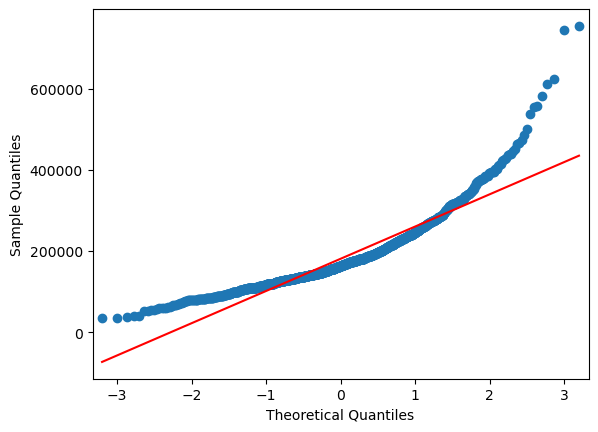

In [34]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(df['SalePrice'], line='s');

From the QQ plot of `SalePrice`:
- **Lower Tail**: In the lower tail (left side of the plot), the data points lie below the red line. This indicates that the distribution of `SalePrice` has heavier tails on the lower side than the normal distribution.
- **Upper Tail**: In the upper tail (right side of the plot), the data points deviate significantly from the red line, suggesting a long tail or skewness to the right. This indicates that there are more extreme high values in `SalePrice` than would be expected in a normal distribution.
- **Central Portion**: The central portion of the data points doesn't align perfectly with the line, suggesting possible deviations from normality in the main body of the distribution as well.

**Conclusion:**

The `SalePrice` data is not normally distributed. It appears to be right-skewed with potential outliers on the higher end and has heavier tails than a normal distribution. This could influence decisions about data transformations or the types of statistical methods applied to the data. For instance, a log transformation could be considered to address the skewness and make the data more normally distributed.

---

## 💡 Check for understanding

**Scenario**:
Given the 'GrLivArea' column (above-ground living area in square feet) and 'SaleCondition' (condition of sale), let's analyze the distribution of living area sizes based on different sale conditions.

**Tasks**:

1. **Data Aggregation**:
    - Create a frequency table for 'SaleCondition' to see the distribution of different sale conditions.
    - Calculate the mean, median, and standard deviation of 'GrLivArea' for each sale condition.

2. **Visualization**:
    - Plot a box plot for 'GrLivArea', categorized by 'SaleCondition'. This will help visualize the central tendencies and spreads for each sale condition.
    - Plot a histogram for 'GrLivArea' of houses with a 'SaleCondition' of "Abnormal" to understand the distribution of living areas for houses with abnormal sale conditions.

3. **Interpretation**:
    - Which sale condition has the highest median living area?
    - Are there any noticeable outliers in the box plot? If so, in which sale conditions are they more prevalent?
    - Based on the histogram for 'Abnormal' sale conditions, how would you describe the distribution of the living area?

In [ ]:
# Your code goes here

## 💡 Check for understanding

Tukey's test for outliers involves using the interquartile range (IQR) to determine if values are outliers. While there isn't a direct "Tukey's test" function in Python's standard libraries, you can easily compute it using the IQR.

Here's how you can perform Tukey's test for outliers:

1. Calculate the first quartile (Q1) and third quartile (Q3) for the data.
2. Compute the interquartile range: \( \text{IQR} = Q3 - Q1 \).
3. Identify outliers:
   - Values less than \( Q1 - 1.5 \times \text{IQR} \)
   - Values greater than \( Q3 + 1.5 \times \text{IQR} \)

Here's a Python function that implements Tukey's test for outliers:

In [ ]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers


```python
# Example usage:
data_series = df['ColumnName']  # replace 'ColumnName' with your specific column
outliers = tukeys_test_outliers(data_series)
print(outliers)
```

This function returns the values in the data that are considered outliers according to Tukey's method.

If you want to **modify the outlier values**, you can replace them with a specific value, such as the median, or the bounds defined by Tukey's method.

If you wish to **delete the outliers**, you can simply filter them out.

Implement these three approaches modifying the function above.

In [ ]:
# Your code goes here